In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-whitegrid')

> "Un mapa no es el territorio que representa, pero si es correcto, tiene una estructura similar a la del territorio" - Alfred Korzybski

Todos los modelos son erróneos, en el sentido de que solo son aproximaciones que se utilizan para intentar comprender un problema a través de datos y no una copia literal del _mundo real_. Si bien todos los modelos son incorrectos, no todos los modelos son igualmente incorrectos; Algunos modelos serán mejores que otros al describir los mismos datos. En los capítulos anteriores, centramos nuestra atención en el problema de inferencia, es decir, cómo aprender el valor de los parámetros a partir de los datos. En este capítulo, nos centraremos en un problema complementario: cómo comparar dos o más modelos utilizados para explicar los mismos datos. Como veremos, este no es un problema simple de resolver y, al mismo tiempo, es un problema central en el análisis de datos.

En el presente capítulo, exploraremos los siguientes temas:

* Overfitting y underfitting
* Criterios de información
* Factores de Bayes
* Regularización de antecedentes

## Pruebas predictivas a posteriori

En el capítulo 1 presentamos el concepto de verificación predictiva posterior. Y en los capítulos de subsecuencia, lo hemos utilizado como una forma de evaluar qué tan bien los modelos explican los mismos datos que se usan para ajustarse al modelo. El propósito de los controles predictivos posteriores no es imponer que un modelo es incorrecto; ¡Ya lo sabemos! El objetivo del ejercicio es comprender qué tan bien estamos capturando los datos. Es frecuente que capturemos diferentes aspectos de los datos de diferentes maneras. Al realizar verificaciones predictivas posteriores, esperamos comprender mejor las limitaciones de un modelo, ya sea para reconocerlas adecuadamente o para intentar mejorar el modelo. Implícitamente en estas estadísticas está el hecho de que el modelo no generalizará la reproducción de todos los aspectos de un problema y, por lo general, no es un problema dado que los modelos se construyen con un propósito en mente. Una verificación predictiva posterior es una forma de evaluar ese propósito, por lo tanto, si tenemos más de un modelo, podemos compararlos mediante verificaciones predictivas posteriores.

Como ya vimos, las verificaciones predictivas posteriores a menudo se realizan mediante visualizaciones como en el siguiente ejemplo:

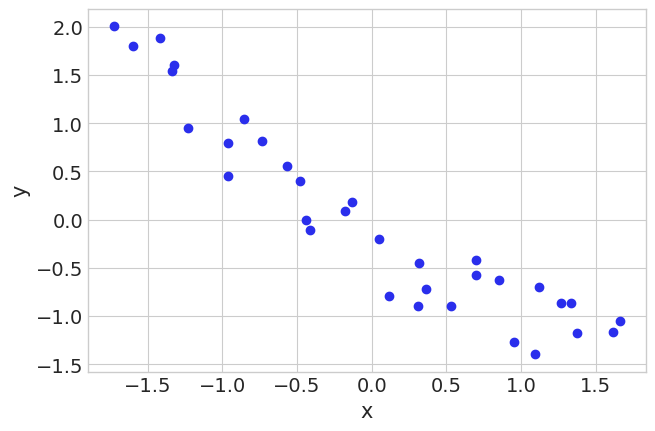

In [3]:
dummy_data = np.loadtxt('datos/dummy.csv')
x_1 = dummy_data[:,0]
y_1 = dummy_data[:,1]

order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y');

Ahora, vamos a ajustar estos datos con dos modelos ligeramente diferentes, uno lineal y el otro un
polinomio de orden 2, también conocido como modelo parabólico o cuadrático:

In [4]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + β * x_1s[0]
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    trace_l = pm.sample(2000)

with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + pm.math.dot(β, x_1s)
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    trace_p = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]


The acceptance probability does not match the target. It is 0.8786480294751476, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]


The acceptance probability does not match the target. It is 0.8888470896979112, but should be close to 0.8. Try to increase the number of tuning steps.


Ahora, vamos a visualizar el ajuste para ambos modelos:

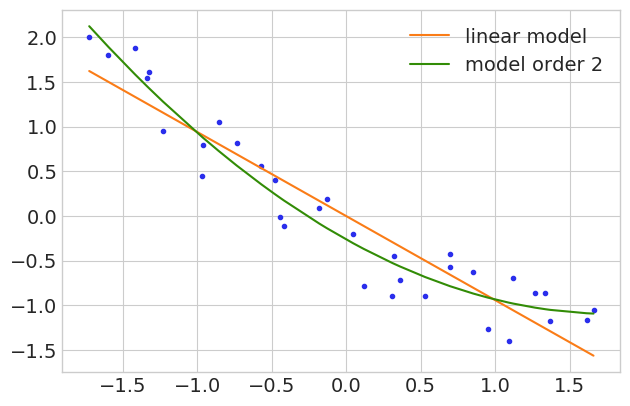

In [5]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = trace_l['α'].mean()
β_l_post = trace_l['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post *  x_new

plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
y_p_post = α_p_post + np.dot(β_p_post, x_new_p) 

plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend();

El modelo de orden 2 parece estar haciendo un mejor trabajo, pero el modelo lineal no es tan malo. Vamos a
Utilice PyMC3 para obtener muestras predictivas posteriores para ambos modelos:

In [7]:
y_l = pm.sample_posterior_predictive(trace_l, 2000, model=model_l)['y_pred']
y_p = pm.sample_posterior_predictive(trace_p, 2000, model=model_p)['y_pred']

/home/osvaldo/proyectos/00_BM/pymc3/pymc3/sampling.py:1543: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/home/osvaldo/proyectos/00_BM/pymc3/pymc3/sampling.py:1543: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Como ya vimos, las pruebas predictivas _a posteriori_ a menudo se realizan mediante visualizaciones, como
en el siguiente ejemplo:

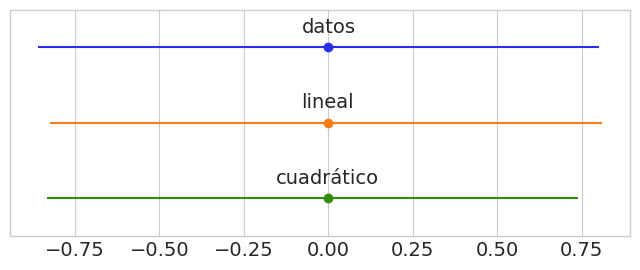

In [8]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['datos', 'lineal', 'cuadrático']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([]);

El diagrama anterior muestra la media y el rango intercuartil (IQR) para los datos y
para los modelos lineales y cuadráticos. En este diagrama, estamos promediando sobre la distribución predictiva _a posteriori_ para cada modelo. Podemos ver que la media está bien capturada por ambos modelos, y que el rango intercuántil no está muy fuera de lugar, pero hay algunas pequeñas diferencias que, en un problema real, podrían ser dignas de atención.

Podríamos hacer muchos otros gŕaficos para explorar distribución predictiva _a posteriori_. Por ejemplo podríamos graficar la dispersión de tanto la media como el rango intercuartil (y no solo sus valores medios):

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color':c},
                   label=f'valor p = {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()
plt.tight_layout()

En la figura anterior también se incluye un _valor p_. Estos _valor p_ son una forma numérica de resumir una comparación entre datos simulados y datos reales. Para obtenerlos se elige un estadístico sumario, como por ejemplo la media, el cual es calculado tanto para los datos como para las simulaciones. Luego contamos la proporción de veces que es estadístico para la simulación es igual o mayores que el calculado a partir de los datos. Si los datos y la simulación concuerdan, deberíamos esperar un _valor p_ de 0.5, de lo contrario, estamos en presencia de una distribución predictiva _a posteriori_ sesgada.


Si estás familiarizado con los métodos frecuentistas es posible que ya conozcas el concepto de _valor p_. Además es posible que hayas escuchado que en estadística Bayesiana no se usan _valores p_. Por lo que este ejemplo puede generarte confusión. Si ese es el caso dejame explicar. Estos _valores p_ Bayesianos son efectivame _valores p_ ya que se definen de forma equivalente que sus _primos_ frecuestistas

$$\text{Bayesian p-value } \triangleq p(T_{\mathcal{sim}} \ge T_{\mathcal{obs}} ) \mid \hat y)$$

Esto es, la probabilidad de obtener un estadístico $T_{sim}$, a partir de las simulaciones, es igual o más extremo que la de obtener un valor de estadísitco $T_{obs}$ a partir de los datos. En principio $T$ puede ser casi cualquier cantidad derivada de los datos. En la figura anterior $T$ es la media (panel izquierda) o el rango interquartil (panel de la derecha). En este ejemplo es razonable que la media _de bien_ por que precisamente el modelo lineal está construido para capturar la media. En general un estadístico que sea _ortogonal_ a lo que el modelo ajusta de forma directa será más informativo. Ante la duda puede ser conveniente evaluar más de un estadístico.

Lo **Bayesiano** de estos _valores p_ es que NO estamos usando una distribución de muestreo sino _la distribución predictiva a posteriori_. Además NO estamos asumiendo ninguna hiótesis nula para calcular el valor p. En cambio, estamos, permitiendo que los parámetros varíen de acuerdo con el modelo y los datos. Otra diferencia más es que no estamos usando ningún método predefinido para declarar significación estadística, ni estamos realizando pruebas de hipótesis, solo estamos calculando un número que cuantifique el ajuste de la distribución predictiva posterior a un conjunto de datos.

Las pruebas predictivas _a posteriori_, ya sea utilizando gráficos o resúmenes numéricos como los _valores p bayesianos_, o incluso una combinación de ambos son ideas muy flexibles. El concepto es lo suficientemente general para permitir que una analista use su imaginación para encontrar diferentes formas de explorar la distribución predictiva _a posteriori_ y use las que mejor se ajusten a los fines de poder interpretar los datos y modelos.

En las siguientes secciones vamos a explorar otros métodos para comparar modelos.

# La navaja de Occam: simplicidad y exactitud

Al elegir entre explicaciones alternativas, existe un principio conocido como la navaja de Occam que establece de manera general que si tenemos dos o más explicaciones equivalentes para el mismo fenómeno, debemos elegir la más simple.

Hay muchas justificaciones para esta heurística; Una de ellas está relacionada con el criterio de falsabilidad introducido por Popper, otra tiene una perspectiva más pragmática y afirma que, dado que los modelos más simples son más fáciles de entender que los modelos más complejos, debemos tratar de quedarnos con el más simple. Otra justificación se basa en propia estadísticas Bayesiana, como veremos cuando analicemos los Factores de Bayes. Sin entrar en los detalles de estas justificaciones, vamos a aceptar este criterio como una regla útil para el momento, simplemente algo que suena como una guía razonable.

Otro factor que generalmente debemos tener en cuenta al comparar modelos es su exactitud, es decir, qué tan bueno es un modelo ajustando los datos. Ya hemos visto algunas medidas de precisión, como el coeficiente de determinación R², que podemos interpretar como la proporción de varianza explicada en una regresión lineal, y también las pruebas predictivas _a posteriori_. Si tenemos dos modelos y uno de ellos explica los datos mejor que el otro, deberíamos preferir ese modelo, es decir, queremos el modelo con mayor exactitud, ¿verdad?


Intuitivamente, parece que al comparar modelos, tendemos a preferir aquellos que tienen alta exactitud y aquellos que son simples. Hasta ahora todo bien, pero ¿qué hacer si el modelo más simple tiene la peor precisión? ¿Y de forma más general cómo se balancean ambas contribuciones?

Durante el resto de este capítulo, vamos a discutir esta idea de balance entre estas dos contribuciones. Este capítulo es más teórico que los capítulos anteriores (incluso cuando solo estamos rascando la superficie de este tema). Pero vamos a utilizar código, figuras y ejemplos que nos ayudarán a pasar de esta intuición (correcta) de equilibrio entre exactitud y complejidad a una justificación con mayor fundamento teórico.


Vamos a comenzar por combinar polinomios cada vez más complejos en un conjunto de datos muy simple. En lugar de utilizar la maquinaria bayesiana, usaremos la aproximación de mínimos cuadrados para ajustar modelos lineales. Recuerde que este último se puede interpretar desde una perspectiva bayesiana como un modelo con _a prioris_ planos. Entonces, en cierto sentido, seguimos siendo Bayesianos solo que estamos tomando un atajo ;-)

In [ ]:
x = np.array([4.,5.,6.,9.,12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

plt.figure(figsize=(9, 6))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2) 
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')

plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0);
#plt.plot([10, 7], [9, 7], 'ks')

## Demasiados parámetros conducen a sobreajuste

De la figura anterior podemos ver que el aumento de la complejidad del modelo se acompaña de una mayor exactitud reflejada en el coeficiente de determinación R². De hecho, podemos ver que el polinomio de orden 5 se ajusta perfectamente a los datos, obteniendo un R²=1. 

¿Por qué el polinomio de grado 5 puede capturar los datos sin perder uno solo de ellos? La razón es que tenemos el mismo número de parámetros que de datos es decir 6. Por lo tanto, el modelo está actuando simplemente como una forma alternativa de expresar los datos. El modelo no está aprendiendo algo sobre los datos, ¡Está memorizando los datos! A partir de este simple ejemplo, podemos ver que un modelo con mayor precisión no siempre es lo ideal.

Imagina que obtenemos más dinero o tiempo y, por lo tanto, recopilamos más datos para sumar al conjunto de datos que ya teníamos. Por ejemplo, recolectamos los puntos [(10, 9), (7,7)] (volvé a correr la celda anterior, descomentando la última linea). ¿Qué tan bien explica el modelo de orden 5 esos nuevos datos? ¿Qué tan bien lo hacen los modelos de orden 1 o 2? El modelo de orden 5 no aprendió ningún patrón interesante en los datos; en lugar de eso, simplemente memorizó cosas (perdón por insistir con esta idea) y, por lo tanto, el modelo de orden 5 hace un trabajo muy malo en generalizar datos futuros, es decir hace malas predicciones.


Cuando un modelo ajusta muy bien, el conjunto de datos utilizado para aprender los parámetros de ese modelo, pero muy mal otros conjuntos de datos, decimos que tenemos sobreajuste (overfitting). Este es un problema muy común al analizar datos.

Una forma muy útil de pensar el sobreajuste es pensar que un conjunto de datos tienen dos componentes; La señal y el ruido. La señal es lo que queremos capturar (o aprender) de los datos. Si usamos un conjunto de datos es porque creemos que hay una señal allí, de lo contrario será un ejercicio futil. El ruido, en cambio, no es útil y es el producto de los errores de medición, las limitaciones en la forma en que se generaron o capturaron los datos, la presencia de datos corruptos, etc. Un modelo sobreajusta cuando es tan flexible (para un conjunto de datos) que es capaz de _aprender_ el ruido. Esto tiene como consecuencia que la señal queda oculta. Esta es una justificación práctica para la navaja de Occam. Y nos advierte que al menos en principio, siempre es posible crear un modelo tan complejo que explique todos los detalles, incluso los más irrelevantes. Tal como en el Imperio descripto por Borges, donde los cartógrafos alcanzaron tal nivel de sofisticación que crearon un Mapa del Imperio cuyo tamaño era el del Imperio, y que coincidía punto por punto con él.



## Muy pocos parámetros conducen a un subajuste

Continuando con el mismo ejemplo pero en el otro extremo de complejidad, tenemos el modelo de orden 0. Este modelo es simplemente una Gaussiana disfrazada de modelo lineal. Este modelo solo es capaz de capturar el valor de la media de $y$ pero es independiente de los valores de $x$. Decimos que este modelo ha sub-estimado los datos.


## El equilibrio entre simplicidad y exactitud

_Todo debe hacerse tan simple como sea posible, pero no más simple_ es una cita que a menudo se atribuye a Einstein y es similar a la navaja de Occam. Al igual que en una dieta saludable, al modelar tenemos que mantener un balance. Idealmente, nos gustaría tener un modelo que ni sub-ajuste ni sobre-ajuste los datos. De alguna forma hay que balancear ambos términos.

Este balance se discute generalmente en términos de varianza y sesgo:

* Alto sesgo es el resultado de un modelo con poca capacidad para acomodar los datos. Un alto sesgo puede hacer que un modelo pierda el patrón relevante y, por lo tanto, puede llevar a un sub-ajuste.

* Alta varianza es el resultado de un modelo con alta sensibilidad a los detalles en los datos. La alta varianza puede hacer que un modelo capture el ruido en los datos y, por lo tanto, puede llevar a un sobre-ajuste.

En las dos figuras anteriores el modelo de orden 0 es el que tiene un sesgo más alto (y una varianza más baja), debido a que está _sezgado hacia_ lineas rectas y paralellas al eje x. El modelo de orden 5 es el que tiene una varianza más alta (y un sesgo más bajo), la forma más fácil de ver esto en la práctica es generar  diferentes conjuntos de datos, todos de seis puntos, y ajustar el modelo a cada uno de ellos. Los seis puntos se pueden organizar de maneras muy diferentes y este modelo se adaptará a casi todos estos conjuntos de datos de forma perfecta, algunos ejemplos que no podrá ajustar serán puntos dispuestos de forma radial.

Un modelo con alto sesgo es un modelo con más prejuicios (si se me perdona la antropomorfización) o más inercia (si se me perdona la fisicalización), mientras que un modelo con alta varianza es un modelo más _abierto_. El problema de estar demasiado sesgado es que no estás preparado para aceptar nueva evidenci, el problema de ser demasiado abierto es que terminas por creer cualquier cosa, como los terraplanistas o loss antivacunas.

En general, cuando aumentamos el sezgo disminuimos la varianza. Una vez más, la idea principal es que queremos un modelo balanceado.

## Medidas de exactitud predictiva

En el ejemplo previo, es relativamente facil de ver que el modelo de orden 0 es _demasiado_ simple mientras que el modelo de orde 5 es _demasiado_ complejo. Pero que podemos decir de los otros dos modelos? Cómo podríamos establecer un ranking numérico de estos modelos? Para poder hacer esto necesitamos formalizar nuestra intuición sobre este balance entre simplicidad y exactitud

Veamos un par de términos que nos serán de utilidad.

* **Exactitud dentro de la muestra** (within-sample accuracy). La exactitud medida con los mismos datos usado para ajustar el modelo.
* **Exactitud fuera de la muestra** (out-of-sample accuracy). La exactitud medida con datos no usados para ajustar el modelo.

La exactitud dentro de la muestra será, en promedio, menor a la exactitud fuera de la muestra. Es por ello que usar la exactitud dentro de la muestra para evaluar un modelo en general conducirá a pensar que tenemos un mejor modelo de lo que realmente es. Utilizar la exactitud fuera de la muestra es por lo tanto una mejor idea para evitar engañarnos a nosotros mismos. Sin embargo, esta aproximación requiere dejar datos fuera del ajuste, lo cual es un lujo que en general no nos podemos dar. Ya que este es un problema central en el análisis de datos existen varias propuestas para abordarlo. Dos aproximaciones muy populares son:


* Validación cruzada: esta es una estrategia empírica basada en dividir los datos disponibles en subconjuntos separados que se utilizan para ajustar y evaluar de forma alternativa

* Criterios de información: este es un término general usado para referirse a varias expresiones que  aproximan la exactitud fuera de la muestra como la exactitud dentro de la muestra más un término que penaliza a modelos complejos.


### Validación cruzada

La validación cruzada es una solución simple y, en la mayoría de los casos, efectiva para comparar modelos. Tomamos nuestros datos y los dividimos en K porciones. Intentamos mantener las porciones más o menos iguales (en tamaño y, a veces, también en otras características, como, por ejemplo, un número igual de clases). Luego usamos K-1 porciones para entrenar el modelo y el resto para evaluarlo. Este proceso se repite sistemáticamente dejando, por cada iteración, una porción diferente fuera del conjunto de entrenamiento y usando esa porción como el conjunto de validación. Esto se repite hasta que hayamos completado K rondas de ajuste-evaluación. La exactitud del modelo será la del promedio a lo largo de las K rondas. Esto se conoce como validación cruzada K-fold. Cuando K es igual a la cantidad de puntos de datos, obtenemos lo que se conoce como _validación cruzada dejando un punto afuera_ (LOOCV del inglés leave-one-out cross-validation). Al hacer LOOCV, el número de rondas suele ser menor que la candidad total de datos. Por último una vez que hemos relizado la validación cruzada, usamos todos los datos para ajustar por última vez nuestro modelo y este es el modelo que se utiliza para hacer predicciones o cualquier otro fin.

<img src='img/cv.png' width=500 >


La validación cruzada es una práctica estádard en en _machine learning_. Y apenas hemos descripto los aspectos más esenciales de esta práctica. Para mayor información pueden leer The Hundred-Page Machine Learning Book](http://themlbook.com/)  o [Python Machine Learning](https://www.amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow-ebook/dp/B0742K7HYF/ref=dp_ob_title_def), by Sebastian Raschka, o [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake Vanderplas.


La validación cruzada es una idea muy simple y útil, pero para algunos modelos o para grandes cantidades de datos, el costo computacional de la validación cruzada puede estar más allá de nuestras posibilidades. Muchas personas han tratado de encontrar cantidades más simples de calcular que se aproximen a los resultados obtenidos con la validación cruzada o que funcionen en escenarios donde la validación cruzada no puede ser tan fácil de realizar. Y ese es el tema de la siguiente sección.

### Criterios de información


Los criterios de información son una colección de herramientas estrechamente relacionadas que se utilizan para comparar modelos en términos de la bondad del ajuste y de la complejidad del modelo. En otras palabras, los criterios de información formalizan la intuición que desarrollamos al comienzo del capítulo. 
La forma exacta en que se derivan estas cantidades tiene que ver con un campo conocido como Teoría de la información, algo que está fuera del alcance de este libro, así que vamos limitarnos a comprenderlos desde un punto de vista práctico.


#### El log-likelihood y la *deviance*

Una forma intuitiva de medir qué tan bien un modelo se ajusta a los datos es calcular el error cuadrático medio entre los datos y las predicciones realizadas por el modelo:


$$\frac{1}{n} \sum_{i=1}^{n}  (y_i - \operatorname{E} (y_i \mid \theta))^2$$


$\operatorname{E} (y_i \mid \theta)$ es el valor predicho dados los parámetros estimados. Es importante notar que esto es esencialmente el promedio entre la diferencia entre los datos observados y los predichos.
Tomar el cuadrado de los errores asegura que las diferencias no se cancelen y enfatiza grandes errores comparado con otros alternativas como por ejemplo calcular el valor absoluto.

El error cuadrático medio, puede resultarnos familiar ya que es muy popular. Pero si nos detenemos a reflexionar sobre esta cantidad veremos que en principio no tiene nada de especial y bien podríamos idear otras expresiones similares. Cuando adoptamos una aproximación probabilista vemos que una expresión más general (y *natural*) es la siguiente:

$$ \sum_{i=1}^{n} \log p(y_i \mid \theta)$$

Esto es, la suma (sobre $n$ datos) de los _likelihoods_ (en escala logarítmica). Esta expresión es más general por que cuando $p(y_i \mid \theta)$ es una gaussiana entonces la suma de log-likelihood será proporcional al error cuadrático medio. Es decir que al elegir un likelihood en un modelo estamos eleigiendo implícitamente una métrica para evaluar el ajuste del modelo. De hecho esto es precisamente lo que hemos estado haciendo al definir modelos Bayesianos. Cuando se discuten criterios de información y por razones puramente históricas suele ser común hablar de _deviance_ que es simplemente:

$$-2\ \sum_{i=1}^{n} \log \ p(y_i \mid \theta)$$

Es decir el log-likelihood multiplicado por -2.


La *deviance* es usada en contextos Bayesianos y no Bayesianos, la diferencia es que bajo un marco Bayesiano
$\theta$ es representado por una distribución de probabilidad y no por una estimación puntual.


* Cuanto menor es la _deviance_, mayor es el likelihood y mayor es el acuerdo entre las predicciones del modelo y los datos. Es decir, a menor *deviance*, mejor ajuste
* La *deviance* se calcula a partir de los datos usados para ajustar el modelo es por lo tanto una forma de estimar la exactitud dentro de la muestra. Como ya vimos esto significa que en promedio la *deviance* va a tender a elegir modelos más complejos, necesitamos por lo tanto algún criterio para balancear esa tendencia. 


En las siguientes secciones, aprenderemos sobre diferentes criterios de información. Los cuales tienen en común el uso de la *desviace* y un término de penalización. La diferencia radica en cómo se calculan cada uno de estos dos términos.

#### Criterio de información de Akaike 

Este es un criterio de información muy conocido y ampliamente utilizado fuera del universo Bayesiano y se define como:

$$AIC = -2 \sum_{i=1}^{n} \log p(y_i \mid \hat{\theta}_{mle}) + 2 pAIC $$

Donde, pAIC es el número de parámetros del modelo y $\hat{\theta}_{mle}$ es la estimación por máxima verosimilitud para $\theta$. 


La estimación de máxima verosimilitud es una práctica común para los no-bayesianos y, en general, es equivalente a la estimación bayesiana del máximo a posteriori (MAP) cuando se usan priors *planos*. Es importante notar que $\hat{\ theta}_{mle} $ es una estimación puntual y no una distribución.

Acá vemos como el factor $-2$ aparece de nuevo, como ya dijimos esto tiene razones históricas y no es relevante ya que es una constante. Lo importante, desde el punto de vista práctico, es que el primer término toma en cuenta cuan bien el modelo ajusta los datos, mientras que el segundo término penaliza la complejidad del modelo. Por lo tanto si dos modelos ajustan los datos igualmente bien. AIC dice que deberemos elegir aquel modelo con el menor número de parámetros, lo cual nos recuerda a la navaja de Ocam.


AIC funciona bien en enfoques no-bayesianos, pero de lo contrario es problemático. Una de las razones es que no utiliza la distribución a posteriori y, por lo tanto, descarta información sobre la incertidumbre en la estimación. Además AIC asume que los priors son *planos* y, por lo tanto, AIC es incompatible con priors informativos y ligeramente informativos como los utilizados en este libro. Tampoco es buena idea usarlo con modelos jerárquicos por lo que ya dijimos y por que la cantidad de parámetros de un modelo no es una buena medida de la complejidad del modelo cuando se usan priors informativos o estructuras como la jerárquica ya que estas son formas de *regularizar* el modelo que es una forma de reducir la complejidad de un modelo. Más adelante volveremos sobre esta idea.

#### Widely applicable information criterion

WAIC es algo así como la versión Bayesiana de AIC, al igual que este último WAIC se compone de dos términos uno que mide el ajuste y otro que penaliza. Como estos términos son un poco más complejos de calcular dejaremos los detalles para otra sección (WAIC en profundidad). Lo importante desde el punto de vista práctico es que WAIC usa todo el posterior (y no una estimación puntual) para el cálculo de ambos términos. Con este se logra que WAIC pueda ser aplicado virtualmente a cualquier modelo Bayesiano.

#### Validación cruzada de dejando uno afuera mediante muestreo de importancia usando un suavizado de Pareto

Este método, tiene un nombre no muy amigable, por lo que en la práctica nos referiremos a el simple,ente como LOO. Conceptualmente este método intenta aproximar los resultados de una validación cruzada a partir de un solo ajuste del modelo. La forma en que este se hace da nombre al método (para más detalles ver LOO en profundidad). Afortunadamente la interpretación de LOO es similar a la de AIC y WAIC; cuanto menor es el valor, mayor es la exactitud predictiva del modelo, por lo tanto, preferimos el modelo con valores más bajos.


#### Otros criterios de información

Otro criterio de información muy usado es DIC, si usamos el *bayesómetero™*  DIC, es más bayesiano que AIC pero menos que WAIC. Aunque aún es popular, WAIC y LOO han demostrado ser más útiles tanto teóricamente como empíricamente que DIC. Por lo cual NO recomendamos su uso.

Otro criterio muy usado es BIC (del inglés Bayesian Information Criteria), al igual que la regresión logística y la * sopa seca * de mi madre, este nombre puede ser engañoso. BIC se propuso como una forma de corregir algunos de los problemas con AIC y el autor propuso una justificación Bayesiana para ello. Pero BIC no es realmente Bayesiano en el sentido que al igual que AIC asume priors *planos* y utiliza una estimación por máxima verosimilitud.

Pero lo que es más importante, es que BIC difiere de AIC y WAIC en su objetivo. AIC y WAIC intentan reflejar cual modelo generaliza mejor a otros datos (exactitud predictiva) mientras que BIC intenta identificar cual es el modelo _correcto_ y por lo tanto está más relacionado los factores de Bayes que con WAIC. Más adelante discutiremos Factores de Bayes y veremos como se diferenci de criterios como WAIC y LOO.

## Calcular los criterios de información con ArviZ

Afortunadamente, calcular los criterios de información con ArviZ es muy simple. Veamos:

In [ ]:
waic_l = az.waic(trace_l)
waic_l

In [ ]:
waic_p = az.waic(trace_p)
waic_p

Lo mismo para LOO.

In [ ]:
loo_l = az.loo(trace_l)
loo_l

In [ ]:
loo_p = az.loo(trace_p)
loo_p

Tanto `az.waic` como `az.loo` devuelven 3 valores

1. Una estimación puntual del criterio de información correspondiente.
2. El error estándar de la estimación puntual
3. El número efectivo de parámetros

Los valores de WAIC o LOO no tienen sentido por si mismos, si no que deben ser interpretados de forma relativa. Es por ello que ArviZ ofrece dos funciones auxiliares para facilitar esta comparación veamos primero a `az.compare`.

In [ ]:
cmp_df = az.compare({'modelo_l':trace_l, 'modelo_p':trace_p}, method='BB-pseudo-BMA')
cmp_df

Explicar cada valor devuelto

También podemos obtener más o menos la misma información de forma gráfica usando la función `az.compareplot`.

In [ ]:
az.plot_compare(cmp_df);

* Los círculos vacíos representan los valores de WAIC, lineas negras representan las barras de error negras asociadas con las estimaciones puntuales.
* El valor más bajo de  WAIC/LOO se indica con una línea gris discontinua vertical para facilitar la comparación con otros valores.
* Los puntos negros rellenos son la *deviance* para cada modelo, es decir sin tener en cuenta la penalización.
* Para todos los modelos, excepto *el mejor*, también obtenemos un triángulo que indica el valor de la diferencia de WAIC/LOO entre cada modelo y el *mejor* modelo. La barra de error gris que indica el error estándar de las diferencias entre las estimaciones puntuales.


La forma más sencilla de utilizar los criterios de información es elegir un único modelo. Simplemente elija el modelo con el valor más bajo del Criterio de información (IC) y olvídese de cualquier otro modelo. Si seguimos esta regla tendremos que aceptar que el modelo cuadrático es el mejor. Incluso si tenemos en cuenta los errores estandar podemos ver que estos no se solapan. Lo que nos da cierta seguridad que efectivamente los modelos son *diferentes* entre si. Si, en cambio, los errores estándar se superpusieran, deberíamos proporcionar una respuesta más matizada.


### Una nota sobre la confiabilidad de los cálculos WAIC y LOO

Al calcular WAIC o LOO, ArviZ puede llegar a ofrecer mensajes de advertencia indicando que el resultado de los cálculos podría no ser confiable. Esta advertencia se genera en función de un valor de corte que se determinó empíricamente. Si bien no es necesariamente problemático, podría estar indicando un problema con el cálculo de estas medidas. WAIC y LOO son relativamente nuevos y probablemente todavía necesitemos desarrollar mejores formas de acceder a su confiabilidad. De todos modos, si esto te sucede, primero asegúrate de tener suficientes muestras del posterior y que el muestreo sea confiable (Ver el capítulo X). Si aún recibes esos mensajes, los autores del método LOO recomiendan modificar el modelo por uno más robusto, como por ejmplo usar una distribución t de Student en lugar de una gaussiana. Si ninguna de estas recomendaciones funciona, puede que sea necesario utilizar otros métodos, como validación cruzada.


## Promedio de modelos

La selección de modelos es atractiva por su simplicidad, pero estamos descartando información sobre la incertidumbre en nuestros modelos. Esto es de alguna manera similar a calcular el posterior completo y luego solo mantener la media del posterior; esto puede conducirnos a confiar demasiado en lo que creemos saber. 

Una alternativa es realizar la selección del modelo, pero informar y analizar los diferentes modelos junto con los valores de los criterios de información calculados, sus valores de error estándar y quizás también las pruebas predictivas a posteriori. Es importante poner todos estos números y pruebas en el contexto de nuestro problema para que nosotros y nuestra audiencia podamos tener una mejor idea de las posibles limitaciones y deficiencias de los modelos. Si trabajas en el mundo académico, puedes utilizar este enfoque para agregar elementos a la sección de discusión de un paper, presentación, tesis, etc.

Otro enfoque, alternativo a la selección de modelos, es promediar los modelos. De esta forma estamos introduciendo la incertidumbre que tenemos sobre la bondad de cada modelo. De esta fora podemos generar un metamodelo (y meta-predicciones) usando un promedio pesdo de cada modelo. Una forma de calcular estos pesos es aplicar esta fórmula:

$$w_i = \frac {e^{ - \frac{1}{2} dIC_i }} {\displaystyle{\sum_j^M e^{ - \frac{1}{2} dIC_j }}}$$


Donde $dIC_i$ es la diferencia entre el valor del criterio de información para el iésimo modelo y el modelo con el IC más bajo. Podemos usar cualquier criterio de información que queramos para calcular un conjunto de pesos, pero, tenemos que apliar el mismo criterio a todos los modelos. 

Esta fórmula es una forma heurística de calcular la probabilidad relativa de cada modelo (dado un conjunto fijo de modelos) a partir de los valores de los criterios de información. Mira cómo el denominador es solo un término de normalización para garantizar que los pesos sumen uno. En el capítulo 4 vimos una expresión similar, la función softmax.

Hay otras formas de promediar modelos, como, por ejemplo, construir explícitamente un metamodelo que incluya todos los modelos de interés como submodelos. Construimos un modelo de tal manera que realizamos inferencia para el parámetro de cada submodelo y al mismo tiempo calculamos la probabilidad relativa de cada modelo (ver la sección Factor de Bayes)

Además de promediar modelos discretos, a veces podemos pensar en versiones continuas de ellos. Por ejmplo para el  problema de lanzar monedas podemos pensar dos modelos diferentes, uno con un un prior hacia las caras y otro hacia las secas. O podemos pensar un modelo jerárquico con un hyperprior que admite a estos dos modelos como casos particulares, junto con una cantidad infinita de otros modelos donde cada uno difiere del otro en el valor que toma el prior. 


¿Qué enfoque es mejor? Depende de nuestro problema concreto. ¿Realmente tenemos buenas razones para pensar en modelos discretos, o nuestro problema está mejor representado como un modelo continuo? Es importante para nuestro problema seleccionar un modelo, porque estamos pensando en términos de explicaciones que compiten, o promediar es una mejor idea porque estmos más interesados en las predicciones. O será que estamos estudiando un problema donde el proceso que genera los datos es una suma de subprocesos? Este tipo de preguntas no puede ser respondido directamemente por la estadística si no que requiere de conocimiento de dominio. La estadística solo puede ayudarnos a pensar respuestas que estén soportadas en datos.

In [ ]:
w = 0.5
y_lp = pm.sample_posterior_predictive_w([trace_l, trace_p], samples=1000, models=[model_l, model_p],
                       weights=[w, 1-w])

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_l, plot_kwargs={'color':'C1'}, label='linear model', ax=ax)
az.plot_kde(y_p, plot_kwargs={'color':'C2'}, label='order 2 model', ax=ax)
az.plot_kde(y_lp['y_pred'], plot_kwargs={'color':'C3'}, label='weighted model', ax=ax)

plt.plot(y_1s, np.zeros_like(y_1s), '|', label='observed data')
plt.yticks([])
plt.legend();

## Factores de Bayes

## Problemas comunes al computar los factores de Bayes

## Comparación entre criterios de información y factores de Bayes

$WAIC = -2 \sum_i^n \log \left(\frac{1}{S} \sum_{s=1}^S p(y_i \mid \theta^s) \right) + 2 \sum_i^n  \left( V_{s=1}^S \log p(y_i \mid \theta^s) \right)$

$-\sum_i p_i \log qi + \sum_i p_i \log ri$